In [1]:
import keras
import random
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")

In [2]:
#######################
!git clone https://gitlab.com/ananddevika266/malayalam-deepocr.git
import os
os.chdir("malayalam-deepocr")

Cloning into 'malayalam-deepocr'...
remote: Enumerating objects: 83399, done.
remote: Counting objects: 100% (83399/83399), done.
remote: Compressing objects: 100% (80605/80605), done.
remote: Total 83399 (delta 2789), reused 83399 (delta 2789), pack-reused 0 (from 0)
Receiving objects: 100% (83399/83399), 385.43 MiB | 21.46 MiB/s, done.
Resolving deltas: 100% (2789/2789), done.
Updating files: 100% (83625/83625), done.


In [ ]:
from keras import backend as K
from keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
from Image_Generator import TextImageGenerator

from parameter import *

In [ ]:
import keras
import random
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D
from keras.layers import AveragePooling2D, Flatten, Activation, Bidirectional
from keras.layers import BatchNormalization, Dropout
from keras.layers import Concatenate, Add, Multiply, Lambda
from keras.layers import UpSampling2D, Reshape
from keras.layers import add,concatenate
from keras.layers import Reshape
from keras.models import Model
from keras.layers import LSTM,GRU
import tensorflow as tf
from parameter import *

MAL_VECTOR = 'ംഃഅആഇഈഉഊഋഌഎഏഐഒഓഔകഖഗഘങചഛജഝഞടഠഡഢണതഥദധനഩപഫബഭമയരറലളഴവശഷസഹാിീുൂൃെേൈൊോൌ്ൎൗൺൻർൽൾ.,'

ASCII_VECTOR = '-+=!@#$%^&*(){}[]|\'"\\/?<>;:0123456789'

ENG_VECTOR = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

CHAR_VECTOR = MAL_VECTOR

letters = [letter for letter in CHAR_VECTOR] # letter array

num_classes = len(letters) + 1               # total length of output chars + CTC separation char

img_w, img_h = 350, 32

# Network parameters
batch_size = 64
val_batch_size = 16

downsample_factor = 4
max_text_len = 60
def ctc_loss_function(args):
    """
    CTC loss function takes the values passed from the model returns the CTC loss using Keras Backend ctc_batch_cost function
    """
    y_pred, y_true, input_length, label_length = args
    # since the first couple outputs of the RNN tend to be garbage we need to discard them, found this from other CRNN approaches
    # I Tried by including these outputs but the results turned out to be very bad and got very low accuracies on prediction
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)


# # Loss and train functions, network architecture
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def get_Model(stage,drop_out_rate=0.35):
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)

    model_input=Input(shape=input_shape,name='the_input',dtype='float32')

    # Convolution layer
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model)

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model)

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model)

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    # CNN to RNN
    model = Reshape(target_shape=((87, 1024)), name='reshape')(model)
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)

    # RNN layer
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model)
    y_pred = Activation('softmax', name='softmax')(model)


    labels = Input(name='the_labels', shape=[max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    #CTC loss function
    loss_out = Lambda(ctc_loss_function, output_shape=(1,),name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

    if stage=='train':
        return model_input,y_pred,Model(inputs=[model_input, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[model_input], outputs=y_pred)

In [ ]:
model_input,y_pred,model=get_Model('train')

In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 the_input (InputLayer)      [(None, 350, 32, 1)]         0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 350, 32, 64)          640       ['the_input[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 350, 32, 64)          256       ['conv1[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 350, 32, 64)          0         ['batch_normalization[0][0

In [ ]:

try:
    model.load_weights('LSTM+BN5--05--15.308.hdf5')
    print("...Previous weight data...")
except:
    print("...New weight data...")
    pass

train_file_path = '/content/malayalam-deepocr/DB/train/train/'
tiger_train = TextImageGenerator(train_file_path, img_w, img_h, batch_size,downsample_factor,60000)   # train only first 50000 images
tiger_train.build_data('/content/malayalam-deepocr/DB/train/train/data.csv')

valid_file_path = '/content/malayalam-deepocr/validation/'
tiger_val = TextImageGenerator(valid_file_path, img_w, img_h, val_batch_size,downsample_factor,160)    # give 45 images for validation
tiger_val.build_data('/content/malayalam-deepocr/validation/data.csv')

from keras import optimizers
adam=optimizers.Adam()

early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=4, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath='LSTM+BN5--{epoch:02d}--{val_loss:.3f}.hdf5', monitor='loss', verbose=1, mode='min', period=1) #chechkpoint
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam,metrics=['accuracy'])

print(tiger_val.n / val_batch_size)
# captures output of softmax so we can decode the output during visualization
history = model.fit_generator(generator=tiger_train.next_batch(),
                    steps_per_epoch=int(tiger_train.n / batch_size),
                    epochs=10, # 10 epochs
                    callbacks=[checkpoint],
                    validation_data=tiger_val.next_batch(),
                    validation_steps=int(tiger_val.n / val_batch_size))

...New weight data...
60000  Image Loading start...


60000
60000
60000
True
True
60000  Image Loading finish...
160  Image Loading start...
160
160
160
True
True
160  Image Loading finish...
10.0
Epoch 1/10
937/937 [==============================] - ETA: 0s - loss: 18.6274 - accuracy: 0.0054
Epoch 1: saving model to LSTM+BN5--01--8.174.hdf5
937/937 [==============================] - 283s 270ms/step - loss: 18.6274 - accuracy: 0.0054 - val_loss: 8.1743 - val_accuracy: 0.0063
Epoch 2/10
937/937 [==============================] - ETA: 0s - loss: 2.2754 - accuracy: 0.4373
Epoch 2: saving model to LSTM+BN5--02--4.055.hdf5
937/937 [==============================] - 254s 271ms/step - loss: 2.2754 - accuracy: 0.4373 - val_loss: 4.0549 - val_accuracy: 0.1625
Epoch 3/10
937/937 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.7434
Epoch 3: saving model to LSTM+BN5--03--3.460.hdf5
937/937 [==============================] - 253s 270ms/step - loss: 1.0988 - accuracy: 0.7434 - val_loss: 3.4603 - val_accuracy: 0.4313
Epoch 4/10
9

In [ ]:
training_accuracy=history.history['accuracy']
training_loss=history.history['loss']
valid_accuracy=history.history['val_accuracy']
valid_loss=history.history['val_loss']

In [ ]:
import pandas as pd
df = pd.DataFrame({'epoches':list(range(1,11)),'accuracy':training_accuracy,'training_loss':training_loss,'validation_accuracy':valid_accuracy,'valiadtion_loss':valid_loss})

In [ ]:
import plotly.express as px
fig = px.line(df,x=df.epoches,y=df.accuracy*100,title='Accuracy over epoches',labels={'y':'Accuracy'})
fig.show()


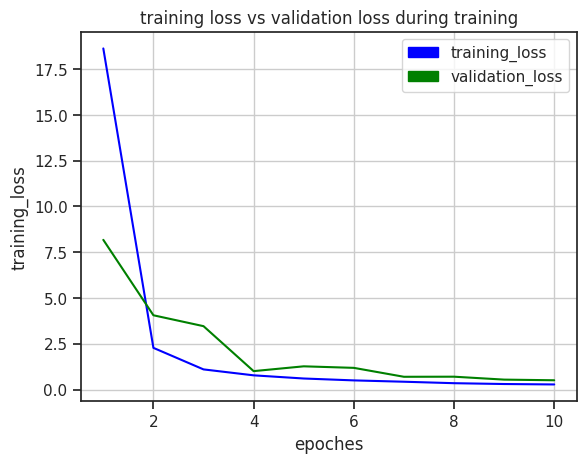

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



sns.set(style="ticks")
plt.grid()
sns.lineplot(x=df.epoches,y=df.training_loss,color='blue')
sns.lineplot(x=df.epoches,y=df.valiadtion_loss,color='green')
blue_patch = mpatches.Patch(color='blue', label='Label1')
green_patch = mpatches.Patch(color='green', label='Label2')

plt.legend(handles =[blue_patch,green_patch],labels=['training_loss','validation_loss'])

plt.title('training loss vs validation loss during training')
plt.show()


In [ ]:
def words_from_labels(labels):
    """
    converts the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT
    """
    txt=[]
    for ele in labels:
        if ele == len(letters): # CTC blank space
            txt.append("")
        else:
            #print(letters[ele])
            txt.append(letters[ele])
    return "".join(txt)

In [ ]:
import numpy as np
import itertools
def decode_label(out):
    """
    Takes the predicted ouput matrix from the Model and returns the output text for the image
    """
    # out : (1, 42, 37)
    # discarding first 2 outputs of RNN as they tend to be garbage
    out_best = list(np.argmax(out[0,2:], axis=1))

    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value

    outstr=words_from_labels(out_best)
    return outstr

In [ ]:
def decode_batch(test_func, word_batch):
    """
    Takes the Batch of Predictions and decodes the Predictions by Best Path Decoding and Returns the Output
    """
    out = test_func([word_batch])[0] #returns the predicted output matrix of the model
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = words_from_labels(out_best)
        ret.append(outstr)
    return ret

In [ ]:
from datetime import datetime
import cv2
def test_data_output_Prediction(model,test_img_names,test_labels):
    """
    Takes the best model, test data image paths, test data groud truth labels and pre-processes the input image to
    appropriate format for the model prediction, takes the predicted output matrix and uses best path decoding to
    generate predicted text and compares with ground truth text for the input and ouputs the final accuracy,
    letter accuracy and  letter count across the entire test set of images, it also returns list of letter mis-match
    count for each test point in the whole test set of images
    """
    start=datetime.now()
    accuracy=0
    letter_acc=0
    letter_cnt=0
    count=0
    letter_mis_match=[]
    for i in range(len(test_labels)):
        test_img=cv2.imread(test_img_names[i])
        test_img_resized=cv2.resize(test_img,(350,32))
        test_image=test_img_resized[:,:,1]
        test_image=test_image.T
        test_image=np.expand_dims(test_image,axis=-1)
        test_image=np.expand_dims(test_image, axis=0)
        test_image=test_image/255
        model_output=model.predict(test_image)
        predicted_output=decode_label(model_output)
        print(predicted_output)
        actual_output=test_labels[i]
        count+=1
        mis_match=0
        for j in range(min(len(predicted_output),len(actual_output))):
            if predicted_output[j]==actual_output[j]:
                letter_acc+=1
            else:
                mis_match+=1
        letter_cnt+=max(len(predicted_output),len(actual_output))
        letter_mis_match.append(mis_match)
        if actual_output==predicted_output:
            accuracy+=1
        if (count%1000)==0:
            print("Processed ",count," Images")
    print("Time Taken for Processing: ",datetime.now()-start)
    return accuracy,letter_acc,letter_cnt,letter_mis_match

In [ ]:
model=get_Model('predict')

In [ ]:
model.load_weights('LSTM+BN5--09--0.541.hdf5')

In [ ]:
import cv2
image_test = ['/content/malayalam-deepocr/DB/test/0.jpg','/content/malayalam-deepocr/DB/test/1.jpg']
imge_test_names = ['കോണ്‍ഫറന്‍സ്','നേതാവും']


In [ ]:
test_data_output_Prediction(model,image_test,imge_test_names)

1/1 [==============================] - 0s 30ms/step
ന്രന്ധ്വദ്യധ്യഗ്യന്ര്സസ്നസ്നന്ൻത്വ
1/1 [==============================] - 0s 29ms/step
കാ്െറെിഢററ്റിന്
Time Taken for Processing:  0:00:00.161249


(0, 0, 49, [12, 7])

In [ ]:
#due to font mismatch we need preprocess and and need to train fonts
#or add the text bounding box before we pass as training dataset

#so we can use tessaract as text bounder and this LSTM model as text predictor
# the LSTM model need to convert to mobile model and add to android package to
#work as application


[Errno 2] No such file or directory: '/content/pottan-ocr'
/content
